In [282]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
import pandas as pd
import os
from glob import glob
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import pickle
import librosa, librosa.display
import random



from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split # train , test 분리에 사용.

from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
from torchcam.methods import ScoreCAM,SmoothGradCAMpp,GradCAMpp


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')

print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.12.1  Device :  cuda


In [283]:
#default param
mfcc_run_config = dict(
    sr=16000,
    n_mfcc=27,
    #dct_type=3, # type2 default
    lifter = 35,

    
    #mel spectro
    n_mels=170,
    hop_length=750,
    n_fft =14056,    
    win_length=1100,
    f_max=8000,
    
    # training
    #batch_size=32,
    mel_scale ='htk',
    
    # data
    fold=1,
)

mel_run_config = dict(
    sr=16000,
    n_mels=128,
    win_length =  300,
    n_fft= 2048,
    hop_length= 50,
    f_max = 8000    
)


spectro_run_config =dict(
    sr=16000,
    n_fft=350,
    hop_length=50,
    win_length=350,
    # training
    batch_size=16,
)




In [284]:
speaker_data=pd.read_excel("../../voice_data/only_organics_healthy_available_ver2.xlsx")

pathology = speaker_data[speaker_data['PATHOLOGY']=='p']['SPEAKER'].unique().tolist()
healthy = speaker_data[speaker_data['PATHOLOGY']=='n']['SPEAKER'].unique().tolist()
print(len(pathology))
print(len(healthy))


#겹치는 speaker는 곱하기 100을 해준다.
#겹치는 speaker는 그대로 둔다.

changed_patients = list(set(healthy) & set(pathology))

for patient in changed_patients:
    temp=pathology[pathology.index(patient)]*100
    pathology[pathology.index(patient)] = temp


#train test 나누기

import os
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split # train , test 분리에 사용.


random_state = 1004 # 1004,1005,1006,1007,1008

X = pathology+healthy # path 데이터 합
print("총 데이터수 : ",len(X))
Y = [] # 라벨
for idx,x in enumerate(X):
    if idx<426:
        Y.append("pathology")
    else:
        Y.append("healthy")

X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y, random_state=random_state) #456
#stratify를 넣어서, test에도 라벨별 잘 분류되게 한다.

print("---")
print("훈련 셋 : ",len(Y),Counter(Y))
print("테스트 셋 : ",len(Y_test),Counter(Y_test))
print("---")


#1. train, test 나누기
#stratified kfold
import os
import random #데이터 shuffle 사용
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter



skf_iris = StratifiedKFold(n_splits=5,shuffle=True,random_state=456)
cnt_iter = 0

X_train_list = [] #데이터 셋 보관
Y_train_list = []

X_valid_list = []
Y_valid_list = []

for train_idx, test_idx in skf_iris.split(X,Y):
    
    #split으로 반환된 인덱스를 이용하여, 학습 검증용 테스트 데이터 추출
    cnt_iter += 1
    X_train, X_valid = [X[idx] for idx in train_idx.tolist() ], [X[idx] for idx in test_idx.tolist() ]
    Y_train, Y_valid = [Y[idx] for idx in train_idx.tolist() ], [Y[idx] for idx in test_idx.tolist() ]
    
    X_train_list.append(X_train)
    X_valid_list.append(X_valid)
    
    Y_train_list.append(Y_train)
    Y_valid_list.append(Y_valid)
    
    
    #학습 및 예측
    
    label_train = Y_train
    label_test = Y_valid
    unique_train, train_counts = np.unique(label_train, return_counts = True)
    unique_test, test_counts = np.unique(label_test, return_counts = True)
    
    uniq_cnt_train = dict(zip(unique_train, train_counts))
    uniq_cnt_test = dict(zip(unique_test, test_counts))
    
    
    
    print('교차 검증 : {}'.format(cnt_iter))
    print('학습 레이블 데이터 분포 : \n', uniq_cnt_train)
    print('검증 레이블 데이터 분포 : \n', uniq_cnt_test,'\n')





# speaker to voice

label_changer = dict({"healthy":"n","pathology":"p"})


all_train_record_list = []
all_valid_record_list = []
all_test_record_list = []

all_train_label_list = []
all_valid_label_list = []
all_test_label_list = []

print("train. speaker to voice")
#train
for fold_idx,fold in enumerate(X_train_list):
    fold_record=[]
    fold_y_record=[]
    for idx,speaker in enumerate(fold):
        record_list = speaker_data[ (speaker_data['SPEAKER']==speaker) & (speaker_data['PATHOLOGY']==label_changer[Y_train_list[fold_idx][idx]])]['RECORDING'].tolist()
        if record_list == []:
            # speaker가 healthy, pathology 모두 있는 경우
            print(speaker)
            speaker = speaker // 100
            record_list = speaker_data[(speaker_data['SPEAKER']==speaker) & (speaker_data['PATHOLOGY']==label_changer[Y_train_list[fold_idx][idx]] ) ]['RECORDING'].tolist()
            print(record_list)

        label_list = [ Y_train_list[fold_idx][idx] ] * len(record_list)       
        fold_record += record_list
        fold_y_record += label_list
    all_train_record_list.append(fold_record)
    all_train_label_list.append(fold_y_record)

print("valid. speaker to voice")
#valid
for fold_idx,fold in enumerate(X_valid_list):
    fold_record=[]
    fold_y_record=[]
    for idx,speaker in enumerate(fold):
        record_list = speaker_data[ (speaker_data['SPEAKER']==speaker) & (speaker_data['PATHOLOGY']==label_changer[Y_valid_list[fold_idx][idx]]) ]['RECORDING'].tolist()
        if record_list == []:
            # speaker가 healthy, pathology 모두 있는 경우
            print(speaker)
            speaker = speaker // 100
            record_list = speaker_data[(speaker_data['SPEAKER']==speaker) & (speaker_data['PATHOLOGY']==label_changer[Y_valid_list[fold_idx][idx]] ) ]['RECORDING'].tolist()
            print(record_list)
        label_list = [ Y_valid_list[fold_idx][idx] ] * len(record_list)
        
        fold_record += record_list
        fold_y_record += label_list
    all_valid_record_list.append(fold_record)
    all_valid_label_list.append(fold_y_record)

print("test. speaker to voice")
#test
fold_record=[]
fold_y_record=[]
for idx,speaker in enumerate(X_test):
    record_list = speaker_data[(speaker_data['SPEAKER']==speaker) & (speaker_data['PATHOLOGY']==label_changer[Y_test[idx]] )]['RECORDING'].tolist()
    if record_list == []:
        # speaker가 healthy, pathology 모두 있는 경우
        print(speaker)
        speaker = speaker // 100
        record_list = speaker_data[(speaker_data['SPEAKER']==speaker) & (speaker_data['PATHOLOGY']==label_changer[Y_test[idx]] ) ]['RECORDING'].tolist()
        print(record_list)
    label_list = [ Y_test[idx] ] * len(record_list)
    fold_record += record_list
    fold_y_record += label_list
all_test_record_list = fold_record
all_test_label_list = fold_y_record


X_train_list = all_train_record_list
X_valid_list = all_valid_record_list
X_test = all_test_record_list

Y_train_list = all_train_label_list
Y_valid_list = all_valid_label_list
Y_test = all_test_label_list





#2. random over sampling
for i in range(5):
    X_temp = np.array(X_train_list[i]).reshape(-1,1)#각 데이터를 다 행으로 넣음. (1194,1)
    #Y = np.array(Y)
    ros = RandomOverSampler(random_state = 123)
    X_res,Y_res = ros.fit_resample(X_temp,Y_train_list[i])
    
    print("\n fold{} ".format(i))
    print('before dataset shape {}'.format(Counter(Y_train_list[i])) )
    print('Resampled dataset shape {}'.format(Counter(Y_res)) )   
    
    #원래대로 돌리기
    X_res=X_res.reshape(1, -1)
    X_train_list[i]=X_res[0].tolist()
    Y_train_list[i]=Y_res




426
630
총 데이터수 :  1056
---
훈련 셋 :  844 Counter({'healthy': 504, 'pathology': 340})
테스트 셋 :  212 Counter({'healthy': 126, 'pathology': 86})
---
교차 검증 : 1
학습 레이블 데이터 분포 : 
 {'healthy': 403, 'pathology': 272}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 68} 

교차 검증 : 2
학습 레이블 데이터 분포 : 
 {'healthy': 403, 'pathology': 272}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 68} 

교차 검증 : 3
학습 레이블 데이터 분포 : 
 {'healthy': 403, 'pathology': 272}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 68} 

교차 검증 : 4
학습 레이블 데이터 분포 : 
 {'healthy': 403, 'pathology': 272}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 68} 

교차 검증 : 5
학습 레이블 데이터 분포 : 
 {'healthy': 404, 'pathology': 272}
검증 레이블 데이터 분포 : 
 {'healthy': 100, 'pathology': 68} 

train. speaker to voice
152400
[932]
7400
[929]
152400
[932]
7400
[929]
152400
[932]
7400
[929]
7400
[929]
152400
[932]
valid. speaker to voice
7400
[929]
152400
[932]
test. speaker to voice
14200
[495]

 fold0 
before dataset shape Counter({'healthy': 406, 'pathology': 3

In [285]:
import torchaudio
#import torchaudio.functional as F
import torchaudio.transforms as T
from torchvision.models import ResNet18_Weights
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
import torchvision.models as models


class ResLayer(nn.Module):
    def __init__(self):
        super(ResLayer, self).__init__()
        self.model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).cuda() 
        #self.num_ftrs = self.model.fc.out_features
        self.num_ftrs = self.model.fc.in_features

        self.model.fc = nn.Sequential(       
            nn.Linear(self.num_ftrs, 64),
                            nn.BatchNorm1d(64),
                            nn.ReLU(),
                            nn.Dropout(p=0.5),
                            nn.Linear(64,50),
                            nn.BatchNorm1d(50),
                            nn.ReLU(),
                            nn.Dropout(p=0.5),
                            nn.Linear(50,2)
                            )

    def forward(self, x):
        #print(x.size())
        x = self.model(x)
        #x  = self.fc(x)
        return x
    
class Resnet_wav(nn.Module):
    def __init__(self, mel_bins=128,win_len=1024,n_fft=1024, hop_len=512):
        #mel_bins=128,win_len=1024,n_fft=1024, hop_len=512
        super(Resnet_wav, self).__init__()
        # if "center=True" of stft, padding = win_len / 2

        #self.num_ftrs = 63

        self.res = ResLayer()


        # self.spec = T.Spectrogram(n_fft=win_len,hop_length=hop_len,power=2)

        # self.mel_scale = T.MelScale(
        #     n_mels=mel_bins, sample_rate=16000, n_stft=win_len // 2 + 1
        #     )

        self.power_to_db = T.AmplitudeToDB(stype="power", top_db=80)

        self.mel_scale = T.MelSpectrogram(
            sample_rate=16000,
            n_fft=n_fft,
            win_length=win_len,
            hop_length=hop_len,
            n_mels=mel_bins,
            f_min=0,
            f_max=8000,
            center=True,
            pad_mode="constant",
            power=2.0,
            norm="slaney",
            mel_scale="slaney",
            window_fn=torch.hann_window
        )

        stretch_factor=0.8
        self.spec_aug = torch.nn.Sequential(
            #T.TimeStretch(stretch_factor, fixed_rate=True),
            T.FrequencyMasking(freq_mask_param=80),
            T.TimeMasking(time_mask_param=40),
        )

    #@classmethod
    def sample_min_max(batch):
        batch_size,height,width = batch.size(0),batch.size(1),batch.size(2)
        batch = batch.contiguous().view(batch.size(0), -1)
        batch -= batch.min(1, keepdim=True)[0]
        batch /= batch.max(1, keepdim=True)[0]
        batch = batch.view(batch_size, height, width)
        return batch

    def batch_min_max(batch):
        batch = (batch-batch.min())/(batch.max()-batch.min())
        return batch
    
    def take_log(feature):
        amp2db = torchaudio.transforms.AmplitudeToDB(stype="amplitude")
        amp2db.amin=1e-5
        return amp2db(feature).clamp(min=-50,max=80)
    

    def forward(self, x,augment=False):
        #spec = self.spec(x)
        #mel = self.mel_spectrogram(x)
        mel = self.mel_scale(x)
        
        mel = torchaudio.functional.amplitude_to_DB(mel,amin=1e-10,top_db=80,multiplier=10,db_multiplier=torch.log10(torch.max(mel)) )
        mel = torch.squeeze(mel,dim=1)        
        #mel = (mel-mel.min())/(mel.max()-mel.min())
        #mel = Resnet_wav.take_log(mel)
        
        mel = Resnet_wav.batch_min_max(mel)

        #mel = self.power_to_db(mel)
        #mel = self.spec_aug(mel)
        #mel = (mel-torch.mean(mel))/torch.std(mel)
        #out = out.mean(axis=2)
        #out=self.fc(out)
        
        #concated_feature = torch.concat([mel,out],axis=2)

        out = torch.stack([mel,mel,mel],axis=1)
        #print(out.size())
        out=self.res(out)
        return out

mel_params={
    "sr": 16000,
    "n_mels": 128,
    "win_length": 400,
    "n_fft": 400,
    "hop_length": 160,
    "f_max": 8000
}

def model_initialize(tsne=False):
    model = Resnet_wav(mel_params['n_mels'],mel_params['win_length'],mel_params['n_fft'],mel_params['hop_length']).cuda()
    model.load_state_dict(torch.load('./checkpoint/checkpoint_ros_fold_1_wav_res_seed_1004_dataset_phrase_norm_false_organics_speaker.pt'))
    #model.load_state_dict(torch.load("../model/Module/checkpoint/checkpoint_ros_fold_1_baseline_seed_1004_norm_false_organics_speaker.pt"))
    #model.load_state_dict(torch.load("../model/Module/checkpoint/checkpoint_ros_fold_2_baseline_seed_1004_norm_false_organics_speaker.pt"))
    #model.load_state_dict(torch.load("../model/Module/checkpoint/checkpoint_ros_fold_3_baseline_seed_1004_norm_false_organics_speaker.pt"))
    #model.load_state_dict(torch.load("../model/Module/checkpoint/checkpoint_ros_fold_4_baseline_seed_1004_norm_false_organics_speaker.pt"))
    #model.load_state_dict(torch.load("../model/Module/checkpoint/checkpoint_ros_fold_5_baseline_seed_1004_norm_false_organics_speaker.pt"))

    model=model.eval()
    return model

model=model_initialize()


In [286]:
from torch.utils.data import Dataset, DataLoader

phras_file_path = "../../voice_data/organics_ver2/phrase_dict_ver2.pickle"
phras_file_path_abs = os.path.abspath(phras_file_path)

class PhraseData():
    
    phrase_dict = dict()

    dict_list = [] # fusion을 위한 dict 리스트

    def __init__(self,phrase_path):
        #load
        
        with open(phrase_path,"rb") as fr:
            PhraseData.phrase_dict = pickle.load(fr)
        return


with open(phras_file_path_abs,"rb") as fr:
    PhraseData.phrase_dict = pickle.load(fr)


classes = ["healthy","pathology"]
class svd_dataset_wav(Dataset):
    def __init__(self,
                data_path_list,
                y_label_list,
                classes,
                mel_params,
                dataset='phrase',
                transform=None,
                is_train=False,):

        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list
        self.label = y_label_list # label data
        self.classes=classes
        self.transform=transform

        self.is_train = is_train

        # sweep params
        self.mel_params = mel_params
        #sr,n_mfcc,lifter, hop_length , win_length , n_mels , n_fft , f_max , batch_size        

        self.dataset=dataset
        #noramlize 관련

        #augmentation들
        # self.crop = None
        # self.spec_augment = None
        # self.augment_params = augment_params
        
        # 이부분을 모델로 옮겨야함. train 여부도 받아야함.
        # if "crop" in augmentation:
        #     self.crop = transforms.RandomApply([
        #                                         Cutout(self.augment_params['crop'][0],
        #                                         self.augment_params['crop'][1]),
        #                                         ],
        #                                         p = self.augment_params['crop'][2])
        # if "spec_augment" in augmentation:
        #     self.spec_augment = transforms.RandomApply([
        #                                             transforms.Compose([T.TimeMasking(time_mask_param=self.augment_params['spec_augment'][0]),
        #                                                                 T.FrequencyMasking(freq_mask_param=self.augment_params['spec_augment'][1]),],)
        #                                        ],
        #                                        p=self.augment_params['spec_augment'][2])

    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다.     
    
    def __getitem__(self, idx):
        """
        WAV 파일을 읽어서, MODEL에 전달.
        """
        #print(str(self.path_list[idx]))
        sig = PhraseData.phrase_dict[ str(self.path_list[idx])+'-'+self.dataset+'.wav' ] 
        #sig = preemphasis(sig)
        
        origin_length = sig.shape[0]
        
        if sig.shape[0] > self.mel_params["sr"]*3:
            origin_length = self.mel_params["sr"]*3
        
        origin_frame_size = 1 + int(np.floor(origin_length//self.mel_params["hop_length"]))
        #print(sig.shape)
        # sig = np.tile(sig,(2,))

        length = self.mel_params["sr"]*3 #sample rate *2 padding을 위한 파라미터 (하이퍼 파라미터로인해 사이즈는 계속 바뀐다.)
        pad1d = lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))        
        sig = pad1d(sig,length)
        
        ###signal norm
        sig = (sig-sig.mean())/sig.std()
        ###

        sig=torch.from_numpy(sig).type(torch.float32)# 타입 변화
        sig=sig.unsqueeze(0)
        
        return sig, self.classes.index(self.label[idx]), str(self.path_list[idx]), origin_length


In [23]:
classes.index(0)

ValueError: 0 is not in list

In [287]:

BATCH_SIZE = 16
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)



validation_loader = DataLoader(dataset = svd_dataset_wav(
                                                    X_valid_list[0],
                                                    Y_valid_list[0],
                                                    classes,
                                                    mel_params = mel_run_config,
                                                    transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                                ),
                                                batch_size = BATCH_SIZE,
                                                shuffle = True,
                                                #worker_init_fn=seed_worker
                                                )#svd_dataset_wav_smile


     
            

In [288]:
for (X_train,Y_train,file_name,_) in validation_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    print("file_name : ",file_name)
    break

X_train :  torch.Size([16, 1, 48000]) type: torch.FloatTensor
Y_train :  torch.Size([16]) type: torch.LongTensor
file_name :  ('155', '1506', '2260', '1330', '1447', '1897', '1259', '1832', '108', '83', '1034', '728', '1810', '1790', '944', '904')


In [289]:
model

Resnet_wav(
  (res): ResLayer(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d

In [290]:
criterion = nn.CrossEntropyLoss()
def test_evaluate(model,test_loader,criterion,DEVICE):
    model.eval()
    test_loss = 0
    predictions = []
    answers = []
    #no_grad : 그래디언트 값 계산 막기.

    file_list = []
    with torch.no_grad():
        for image,label,file_path,_ in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            answers +=label
            predictions +=prediction
            file_list += file_path
            
        return predictions,answers,test_loss,file_list

In [291]:
# 3m 30s
predictions,answers,_,file_list=test_evaluate(model,validation_loader,criterion,DEVICE)

In [292]:
def get_class(class_idx):
    if class_idx==0:
        return 'healthy'
    else:
        return 'pathology'

In [293]:
wrong_answer = []
label_wrong_answer=[]
for i in range(len(predictions)):
    if predictions[i].cpu().numpy()[0] != answers[i].cpu().numpy():
        wrong_answer.append(file_list[i])
        label_wrong_answer.append(answers[i].cpu().item())
label_wrong_answer = [get_class(a) for a in label_wrong_answer]

In [294]:
label_wrong_answer

['healthy',
 'healthy',
 'pathology',
 'healthy',
 'healthy',
 'pathology',
 'pathology',
 'healthy',
 'pathology',
 'pathology',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'pathology',
 'healthy',
 'healthy',
 'pathology',
 'healthy',
 'healthy',
 'healthy',
 'pathology',
 'pathology',
 'pathology',
 'pathology',
 'healthy',
 'pathology',
 'healthy',
 'pathology',
 'pathology',
 'pathology']

In [295]:
right_answer = []
label_right_answer=[]
for i in range(len(predictions)):
    if predictions[i].cpu().numpy()[0] == answers[i].cpu().numpy():
        right_answer.append(file_list[i])
        label_right_answer.append(answers[i].cpu().item())
label_right_answer = [get_class(a) for a in label_right_answer]

In [296]:
label_right_answer

['pathology',
 'pathology',
 'healthy',
 'healthy',
 'pathology',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'pathology',
 'pathology',
 'pathology',
 'pathology',
 'healthy',
 'pathology',
 'pathology',
 'healthy',
 'pathology',
 'healthy',
 'pathology',
 'healthy',
 'healthy',
 'healthy',
 'pathology',
 'healthy',
 'healthy',
 'healthy',
 'pathology',
 'pathology',
 'healthy',
 'pathology',
 'pathology',
 'healthy',
 'pathology',
 'pathology',
 'pathology',
 'healthy',
 'pathology',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'pathology',
 'pathology',
 'healthy',
 'pathology',
 'pathology',
 'healthy',
 'pathology',
 'healthy',
 'healthy',
 'pathology',
 'pathology',
 'pathology',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'pathology',
 'pathology',
 'healthy',
 'pathology',
 'healthy',
 'pathology',
 'pathology',
 'pathology',
 'pathology',
 'healthy',
 'healthy',
 'pathology',
 'healthy',
 'pathology',
 'pathology',
 'pathology',
 'pathology',
 'health

In [297]:
to_csv = pd.DataFrame({"files":wrong_answer})
to_csv.to_csv("./wrong_segment_0329_spec.csv",index=False)
#to_csv.to_csv("./wrong.csv")

In [298]:
wrong_data_list = [a.split('-')[0] for a in wrong_answer]

In [299]:
right_data_list = [a.split('-')[0] for a in right_answer]

In [300]:
label_right_answer

['pathology',
 'pathology',
 'healthy',
 'healthy',
 'pathology',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'pathology',
 'pathology',
 'pathology',
 'pathology',
 'healthy',
 'pathology',
 'pathology',
 'healthy',
 'pathology',
 'healthy',
 'pathology',
 'healthy',
 'healthy',
 'healthy',
 'pathology',
 'healthy',
 'healthy',
 'healthy',
 'pathology',
 'pathology',
 'healthy',
 'pathology',
 'pathology',
 'healthy',
 'pathology',
 'pathology',
 'pathology',
 'healthy',
 'pathology',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'pathology',
 'pathology',
 'healthy',
 'pathology',
 'pathology',
 'healthy',
 'pathology',
 'healthy',
 'healthy',
 'pathology',
 'pathology',
 'pathology',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'pathology',
 'pathology',
 'healthy',
 'pathology',
 'healthy',
 'pathology',
 'pathology',
 'pathology',
 'pathology',
 'healthy',
 'healthy',
 'pathology',
 'healthy',
 'pathology',
 'pathology',
 'pathology',
 'pathology',
 'health

In [301]:
wrong_data_list

['1078',
 '1009',
 '2542',
 '79',
 '94',
 '1764',
 '1832',
 '1511',
 '1897',
 '2243',
 '993',
 '1076',
 '1874',
 '83',
 '1349',
 '1456',
 '72',
 '60',
 '1325',
 '2407',
 '1512',
 '1018',
 '1272',
 '1223',
 '2015',
 '1809',
 '2478',
 '1912',
 '112',
 '1869',
 '1790',
 '1834']

In [302]:
validation_loader =  torch.utils.data.DataLoader(dataset = 
                                           svd_dataset_wav(
                                                    wrong_data_list,
                                                    label_wrong_answer,
                                                    classes,
                                                    mel_params = mel_run_config,
                                                    transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                                ),
                                           batch_size = 1,
                                           shuffle = True,) 



In [167]:
validation_loader =  torch.utils.data.DataLoader(dataset = 
                                           svd_dataset_wav(
                                                    right_data_list,
                                                    label_right_answer,
                                                    classes,
                                                    mel_params = mel_run_config,
                                                    transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                                ),
                                           batch_size = 1,
                                           shuffle = True,) 



In [303]:
for (X_train,Y_train,file_name,_) in validation_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    print("file_name : ",file_name)

X_train :  torch.Size([1, 1, 48000]) type: torch.FloatTensor
Y_train :  torch.Size([1]) type: torch.LongTensor
file_name :  ('1325',)
X_train :  torch.Size([1, 1, 48000]) type: torch.FloatTensor
Y_train :  torch.Size([1]) type: torch.LongTensor
file_name :  ('2407',)
X_train :  torch.Size([1, 1, 48000]) type: torch.FloatTensor
Y_train :  torch.Size([1]) type: torch.LongTensor
file_name :  ('1834',)
X_train :  torch.Size([1, 1, 48000]) type: torch.FloatTensor
Y_train :  torch.Size([1]) type: torch.LongTensor
file_name :  ('79',)
X_train :  torch.Size([1, 1, 48000]) type: torch.FloatTensor
Y_train :  torch.Size([1]) type: torch.LongTensor
file_name :  ('1009',)
X_train :  torch.Size([1, 1, 48000]) type: torch.FloatTensor
Y_train :  torch.Size([1]) type: torch.LongTensor
file_name :  ('1832',)
X_train :  torch.Size([1, 1, 48000]) type: torch.FloatTensor
Y_train :  torch.Size([1]) type: torch.LongTensor
file_name :  ('1018',)
X_train :  torch.Size([1, 1, 48000]) type: torch.FloatTensor
Y_t

AttributeError: 'ResLayer' object has no attribute 'layer4'

In [309]:


model = model.eval()
cam_extractor = GradCAMpp(model,target_layer='res.model.layer4',input_shape=16)
# Get your input
activation_map_list = []
img_list = []
file_list = []

mel_params={
    "sr": 16000,
    "n_mels": 128,
    "win_length": 400,
    "n_fft": 400,
    "hop_length": 160,
    "f_max": 8000
}


mel_scale = T.MelSpectrogram(
            sample_rate=16000,
            n_fft=mel_params['n_fft'],
            win_length=mel_params['win_length'],
            hop_length=mel_params['hop_length'],
            n_mels=mel_params['n_mels'],
            f_min=0,
            f_max=8000,
            center=True,
            pad_mode="constant",
            power=2.0,
            norm="slaney",
            mel_scale="slaney",
            window_fn=torch.hann_window
        )

for (valid_x_data,valid_y_data,file_name_cam,_) in validation_loader:
    print("X_train : ",valid_x_data.size(),'type:',valid_x_data.type())
    print("Y_train : ",valid_y_data.size(),'type:',valid_y_data.type())
    print("file_name : ",file_name_cam)
    #img = read_image("path/to/your/image.png")
    # Preprocess it for your chosen model
    #input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
    #X_train = X_train.unsqueeze(0)
    X_train_imgs=mel_scale(valid_x_data)
    X_train_imgs=torchaudio.functional.amplitude_to_DB(X_train_imgs,amin=1e-10,top_db=80,multiplier=10,db_multiplier=torch.log10(torch.max(X_train_imgs)))
    X_train_imgs = (X_train_imgs-X_train_imgs.min())/(X_train_imgs.max()-X_train_imgs.min())
    img_list.append(X_train_imgs)
    file_list.append(file_name_cam)
    # Preprocess your data and feed it to the model
    #model(valid_x_data.to(DEVICE))


    out = model(valid_x_data.to(DEVICE))
    print("out :",out.size())

    # Retrieve the CAM by passing the class index and the model output
    print(out.argmax(dim=1))
    activation_map = cam_extractor(out.argmax(dim=1).cpu().numpy().tolist(),out)
    activation_map_list.append(activation_map)
    # get wrong answer

    



X_train :  torch.Size([1, 1, 48000]) type: torch.FloatTensor
Y_train :  torch.Size([1]) type: torch.LongTensor
file_name :  ('1272',)
out : torch.Size([1, 2])
tensor([0], device='cuda:0')
X_train :  torch.Size([1, 1, 48000]) type: torch.FloatTensor
Y_train :  torch.Size([1]) type: torch.LongTensor
file_name :  ('83',)
out : torch.Size([1, 2])
tensor([1], device='cuda:0')
X_train :  torch.Size([1, 1, 48000]) type: torch.FloatTensor
Y_train :  torch.Size([1]) type: torch.LongTensor
file_name :  ('1912',)
out : torch.Size([1, 2])
tensor([0], device='cuda:0')
X_train :  torch.Size([1, 1, 48000]) type: torch.FloatTensor
Y_train :  torch.Size([1]) type: torch.LongTensor
file_name :  ('2015',)
out : torch.Size([1, 2])
tensor([0], device='cuda:0')
X_train :  torch.Size([1, 1, 48000]) type: torch.FloatTensor
Y_train :  torch.Size([1]) type: torch.LongTensor
file_name :  ('993',)
out : torch.Size([1, 2])
tensor([1], device='cuda:0')
X_train :  torch.Size([1, 1, 48000]) type: torch.FloatTensor
Y_

In [208]:
activation_map_list[0][0][0]

tensor([[0.7795, 0.4377, 0.3861, 0.2578, 0.2880, 0.4334, 0.4442, 0.4173, 0.4982,
         0.4556, 0.3579, 0.6058, 0.5545, 0.2872, 0.3270, 0.2708, 0.2587, 0.4089,
         0.2863, 0.3643, 0.5401, 0.6915, 0.7134, 0.5774, 0.7324, 0.8525, 0.5426,
         0.4402, 0.4487, 0.4552, 0.4549, 0.4549, 0.4550, 0.4531, 0.4573, 0.5600,
         0.8771, 1.0000],
        [0.7359, 0.4453, 0.3223, 0.4096, 0.4910, 0.7241, 0.6469, 0.2886, 0.5765,
         0.8676, 0.2526, 0.5792, 0.4076, 0.1742, 0.3343, 0.2360, 0.1500, 0.4287,
         0.5967, 0.2801, 0.2307, 0.6589, 0.7377, 0.5224, 0.2047, 0.2634, 0.1527,
         0.1040, 0.1119, 0.1139, 0.1138, 0.1138, 0.1138, 0.1120, 0.1061, 0.1370,
         0.3584, 0.7417],
        [0.4446, 0.2836, 0.3743, 0.6278, 0.4214, 0.5176, 0.4249, 0.1321, 0.7683,
         0.7756, 0.2245, 0.2896, 0.1706, 0.2151, 0.3032, 0.2506, 0.1525, 0.3261,
         0.4510, 0.2064, 0.2752, 0.3062, 0.5841, 0.3097, 0.1408, 0.1046, 0.1449,
         0.1545, 0.1375, 0.1372, 0.1371, 0.1371, 0.1371, 

In [135]:
out.argmax(dim=1).cpu().numpy().tolist()

[1]

In [120]:
img_list[0].size()

torch.Size([16, 1, 128, 301])

In [105]:
img_list[0].size()

torch.Size([16, 1, 128, 301])

In [50]:
img_list[0][0].max()

tensor(0.9400)

In [305]:
from torchcam.utils import overlay_mask
from PIL import Image

In [310]:
def get_concat_h(im1, im2,im3):
    dst = Image.new('RGB', (im1.width + im2.width+ im3.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    dst.paste(im2, (im2.width, 0))
    return dst

In [311]:
from torchvision.transforms.functional import normalize, resize, to_pil_image

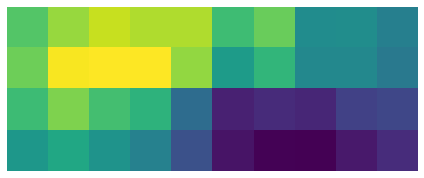

In [312]:
# Visualize the raw CAM
plt.imshow(activation_map[0][0].cpu().squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

In [41]:
activation_map[0][0].shape

torch.Size([4, 10])

In [42]:
grad_result.shape

NameError: name 'grad_result' is not defined

In [201]:
1/(1+np.exp(-(10^3)*0))

0.5

In [249]:
grad_result[0]

array([[-26.116543, -22.58493 , -18.890985, ..., -11.339174, -11.667251,
        -12.420631],
       [-31.568476, -27.700373, -24.412844, ..., -16.347322, -17.799545,
        -18.256758],
       [-35.510174, -32.998318, -31.754606, ..., -23.179586, -21.054417,
        -19.986418],
       ...,
       [-80.      , -80.      , -78.13196 , ..., -46.68914 , -46.21005 ,
        -45.871815],
       [-80.      , -80.      , -80.      , ..., -49.826378, -47.91027 ,
        -46.885895],
       [-80.      , -80.      , -80.      , ..., -51.994347, -48.705276,
        -47.260307]], dtype=float32)

In [313]:

actviation_map_list_persample = []
img_list_persample = []
file_list_persample = []

for active_batch in activation_map_list:
    actviation_map_list_persample+=list(torch.unbind(active_batch[0],dim=0))

for img_batch in img_list:
    img_list_persample+=list(torch.unbind(img_batch,dim=0))

for file_batch in file_list:
    file_list_persample+=list(file_batch)


In [195]:
img_list_persample[0].size()

torch.Size([1, 128, 301])

In [58]:
spectro.size()

NameError: name 'spectro' is not defined

In [314]:
import matplotlib.pyplot as plt

def to_min_max(mel_sample):
    mel_min,mel_max = mel_sample.squeeze()[1].min(),mel_sample.squeeze()[1].max()
    mel_sample = (mel_sample.squeeze()[1]- mel_min).div(mel_max-mel_min)
    return mel_sample


grad_result_list = []

for spectro,activation_map,file in zip(img_list_persample,actviation_map_list_persample,file_list_persample):
    grad_cam_map = F.relu(activation_map) # Apply R e L U
    #print(grad_cam_map.size())
    grad_cam_map = F.interpolate(grad_cam_map.unsqueeze(0).unsqueeze(1), size=(128,301), mode='bilinear', align_corners=False) # (1, 1, 128, 300)
    map_min, map_max = grad_cam_map.min(), grad_cam_map.max()
    grad_cam_map = (grad_cam_map - map_min).div(map_max - map_min).data # (1, 1, 128, 300), min-max scaling
    #print(grad_cam_map.shape)
    grad_result = grad_cam_map[0][0].cpu().numpy() * spectro.view(1,1,128,301).cpu().numpy() # (1, 3, 128, 301)
    #grad_result = grad_cam_map[0][0].cpu().numpy() + spectro[0].view(3,140,87).cpu().numpy()
    grad_result_list.append(grad_result)

    plt.figure(figsize=(30,5),facecolor='white')
    plt.ion()
    plt.subplot(131)
    librosa.display.specshow(spectro[0].cpu().numpy(), sr=16000, hop_length=160)
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar(format='%+2.0f dB')
    plt.title("Spectrogram (dB)")
    plt.subplot(132)
    plt.imshow(grad_cam_map[0][0].cpu().numpy(),origin='lower')

    plt.subplot(133)
    librosa.display.specshow(grad_result[0][0], sr=16000, hop_length=160)
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar(format='%+2.0f dB')
    plt.title("Spectrogram (dB)")

    plt.savefig("../../voice_data/0329_cam_4_spec/"+file+'.png')
    plt.close()




In [243]:
t4d = torch.randn(1,100)
p1d = (0, 200) # pad last dim by 1 on each side
out = F.pad(t4d, p1d, "reflect")  # effectively zero padding
print(out.size())

RuntimeError: Argument #4: Padding size should be less than the corresponding input dimension, but got: padding (0, 200) at dimension 1 of input [1, 100]

In [280]:
t4d = np.random.randn(100,)
print(t4d)
res=np.pad(t4d,(0,100),mode='wrap')#상하, 좌우
print(res)

[-0.66207671  0.79531014  0.44983862  0.93505935 -0.65920528 -0.88286323
  0.60017302  0.81116     1.12902762  2.22110225  1.50162476 -0.88998599
 -1.59321179  1.41891747 -0.28847745 -0.61370353 -0.14567419 -1.38298091
  1.18743516  2.29547893 -0.67860556  0.24920343  0.05666669  0.26369593
 -1.99160738 -0.31400206  0.32958123 -1.88761564  0.40140611  2.23628846
  0.12658033  0.2185718   0.94305088 -1.4263035   0.88511325 -0.80853384
  0.99063489  0.33124034  0.20394435 -0.44753896  2.31669562 -0.70085052
  1.92818014  0.53933566  1.28314334  0.03712441 -1.09813537  1.607137
  0.48907388 -2.66223018 -0.56714552  0.89874329  2.78179874  0.58971173
  0.95820512 -0.87680927  0.6875787  -1.58709693  0.44103165 -0.06678321
 -0.6333423   0.73394954 -0.51778078  0.23531015 -0.35642279  0.40957567
 -0.42060637  1.1789814   1.29204289 -0.36520802 -0.06785223 -0.23978253
  0.55592716 -0.46357939 -1.44952954 -0.16368058  2.23372498 -0.60020652
 -0.96186744 -1.99490508  0.83374951  0.9667723   2.2

In [281]:
res.shape

(200,)

In [248]:
out

tensor([[-1.4344,  0.8426, -0.4687,  0.0871,  1.1367, -0.4709,  0.0742,  0.5391,
         -1.5811, -2.0406,  0.3009, -1.1042,  0.1978,  1.0491, -0.4523,  0.7025,
          0.9659, -0.7824,  1.5075,  1.7360,  0.4123,  1.1813,  1.1990,  0.8898,
          2.4931, -0.7573,  1.6659,  0.9451, -0.5875, -0.9471, -0.5746,  1.8285,
         -0.5035, -0.7229, -0.1440,  2.8538,  0.0566,  0.8660,  1.1747, -1.6141,
         -1.4561, -1.6696,  0.9945,  0.7130,  0.4086, -0.1358,  0.4871,  1.2965,
         -0.2476,  0.0165,  0.3603,  1.5698,  1.5876,  0.8577, -0.3911,  1.3299,
         -0.3593, -0.5235, -1.2921, -0.1275,  1.2501,  0.3460,  0.2203, -2.3820,
         -0.3863,  0.2076, -1.2882,  0.9551,  0.3035,  0.3792, -1.3642, -0.7509,
         -0.2258,  0.9218,  0.0426, -0.0100, -0.8486,  1.7281,  0.7130,  0.5593,
         -0.4376,  0.3916,  0.3606, -0.9313,  1.4125, -2.2194,  1.9791,  0.6872,
         -1.3038,  2.7736, -1.1737,  1.3672,  0.7916, -0.3454,  2.1713,  1.4893,
          0.5121,  0.9296,  

In [223]:
grad_result_list[0]

array([[0.4840142 , 0.58132946, 0.6570041 , ..., 0.36315244, 0.3718897 ,
        0.3708524 ],
       [0.433539  , 0.51754534, 0.5841393 , ..., 0.19457896, 0.20006536,
        0.22638085],
       [0.36316857, 0.39414373, 0.42959705, ..., 0.19457896, 0.19457896,
        0.19457896],
       ...,
       [0.19351752, 0.19351752, 0.19351752, ..., 0.6332096 , 0.6332096 ,
        0.6332096 ],
       [0.19351752, 0.19351752, 0.19351752, ..., 0.6332096 , 0.6332096 ,
        0.6332096 ],
       [0.19351752, 0.19351752, 0.19351752, ..., 0.6332096 , 0.6332096 ,
        0.6332096 ]], dtype=float32)

In [21]:
grad_result_list[0][0].shape

(140, 87)

In [32]:
librosa.__version__

'0.9.0'

In [22]:
grad_result_list[0][0].cpu().numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [259]:
import noisereduce

Text(0.5, 1.0, 'Spectrogram (dB)')

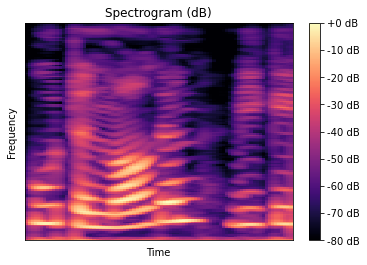

In [264]:
librosa.display.specshow(spectro[0][0].cpu().numpy(), sr=16000, hop_length=370)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

Text(0.5, 1.0, 'Spectrogram (dB)')

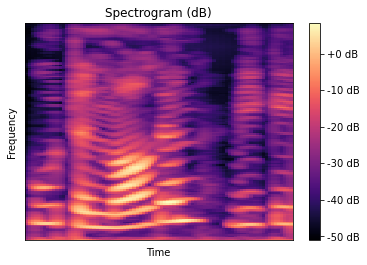

In [263]:
mel=noisereduce.reduce_noise(spectro[0][0].cpu().numpy(),sr=16000)
librosa.display.specshow(mel, sr=16000, hop_length=370)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

In [256]:
from IPython.display import Audio

S = librosa.core.db_to_power(spectro[0][0].cpu().numpy()) 
S = librosa.core.db_to_power(grad_result_list[4]) 
#S = librosa.feature.inverse.mel_to_stft(S,sr=16000,n_fft=4320,power=2.0)
#y = librosa.griffinlim(S)
y = librosa.feature.inverse.mel_to_audio(S,sr=16000, n_fft=4320, hop_length=370, win_length=3400,power=2.0 )
Audio(data=y, rate=16000)
#librosa.

In [115]:
filename = librosa.ex('trumpet')
y, sr = librosa.load(filename, sr=16000)
y

array([-1.0460054e-03, -4.9672596e-04, -6.8871901e-05, ...,
       -8.1366443e-06, -8.9719761e-06,  0.0000000e+00], dtype=float32)

In [125]:

filename = librosa.ex('trumpet')
y, sr = librosa.load(filename, sr=16000)
mel_feature = librosa.feature.melspectrogram(y=y,
                                                sr=mel_run_config["sr"],
                                                # hyp param
                                                n_mels = mel_run_config["n_mels"],
                                                n_fft = mel_run_config["n_fft"],
                                                win_length = mel_run_config["win_length"],
                                                hop_length = mel_run_config["hop_length"],
                                                fmax = mel_run_config["f_max"]
                                            )
mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
mel_feature = librosa.core.db_to_power(mel_feature) 
S = librosa.feature.inverse.mel_to_stft(mel_feature)
y = librosa.griffinlim(S)
Audio(data=y, rate=16000)    

d:\anaconda3\envs\local_torch\lib\site-packages\librosa\core\spectrum.py:2538: UserWarning: n_fft=4320 is too small for input signal of length=87
  stft(
d:\anaconda3\envs\local_torch\lib\site-packages\librosa\core\spectrum.py:2434: UserWarning: n_fft=2048 is too small for input signal of length=0
  rebuilt = stft(


ValueError: zero-size array to reduction operation maximum which has no identity

In [142]:

mel_feature = librosa.core.db_to_power(grad_result_list[8]) 

y = librosa.feature.inverse.mel_to_audio(mel_feature,sr=16000, n_fft=4320, hop_length=370, win_length=3400,power=2.0 )
#y = librosa.griffinlim(S)
Audio(data=y, rate=16000)


In [129]:


spectrogram = librosa.stft(y=y,
                                n_fft = spectro_run_config["n_fft"],
                                win_length = spectro_run_config["win_length"],
                                hop_length = spectro_run_config["hop_length"],
                                            )
magnitude = np.abs(spectrogram)
y_inv = librosa.griffinlim(magnitude)
Audio(data=y_inv, rate=32000)                                        
#spectrogram = librosa.core.power_to_db(mel_feature,ref=np.max) 

In [127]:
y, sr = librosa.load(librosa.ex('trumpet'),sr=16000)
M = librosa.feature.melspectrogram(y=y,
                                                sr=mel_run_config["sr"],
                                                # hyp param
                                                n_mels = mel_run_config["n_mels"],
                                                n_fft = mel_run_config["n_fft"],
                                                win_length = mel_run_config["win_length"],
                                                hop_length = mel_run_config["hop_length"],
                                                fmax = mel_run_config["f_max"]
                                            )
M = librosa.core.power_to_db(M,ref=np.max) 
M = librosa.core.db_to_power(M,ref=np.max) 
S = librosa.feature.inverse.mel_to_stft(M)
y = librosa.griffinlim(S)
Audio(data=y, rate=16000,)

TypeError: unsupported operand type(s) for *: 'function' and 'float'

In [103]:
y, sr = librosa.load(librosa.ex('trumpet'))
# Get the magnitude spectrogram
S = np.abs(librosa.stft(y))
# Invert using Griffin-Lim
y_inv = librosa.griffinlim(S)
Audio(data=y_inv, rate=16000)

In [78]:
from IPython.display import Audio

aud=librosa.feature.inverse.griffinlim(spectrogram)

#librosa.
Audio(data=aud, rate=16000)

In [56]:
Audio(data=y, rate=16000)

Text(0.5, 1.0, 'Spectrogram (dB)')

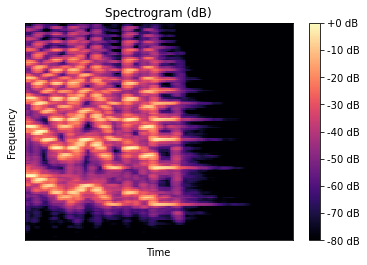

In [51]:
librosa.display.specshow(mel_feature, sr=16000, hop_length=370)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

In [44]:


mel_feature = librosa.feature.melspectrogram(y=aud,
                                                sr=mel_run_config["sr"],
                                                # hyp param
                                                n_mels = mel_run_config["n_mels"],
                                                n_fft = mel_run_config["n_fft"],
                                                win_length = mel_run_config["win_length"],
                                                hop_length = mel_run_config["hop_length"],
                                                fmax = mel_run_config["f_max"]
                                            )
mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max) 

In [45]:
spectro[0][0].size()

torch.Size([140, 87])

Text(0.5, 1.0, 'Spectrogram (dB)')

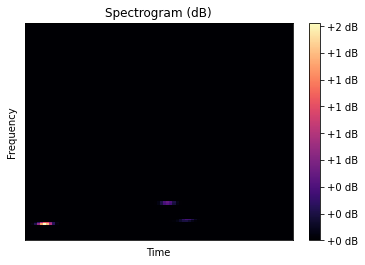

In [46]:
librosa.display.specshow(mel_feature, sr=16000, hop_length=370)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

Text(0.5, 1.0, 'Spectrogram (dB)')

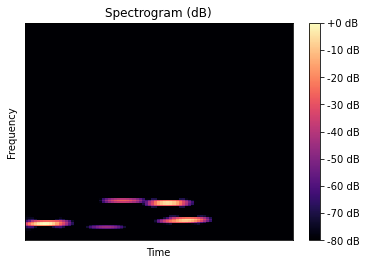

In [26]:
librosa.display.specshow(mel_feature, sr=16000, hop_length=370)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

In [29]:
mel_feature.shape

(140, 87)

In [126]:
??librosa.feature.inverse.mel_to_audio

Signature:
librosa.feature.inverse.mel_to_audio(
    M,
    *,
    sr=22050,
    n_fft=2048,
    hop_length=None,
    win_length=None,
    window='hann',
    center=True,
    pad_mode='constant',
    power=2.0,
    n_iter=32,
    length=None,
    dtype=<class 'numpy.float32'>,
    **kwargs,
)
Source:   
def mel_to_audio(
    M,
    *,
    sr=22050,
    n_fft=2048,
    hop_length=None,
    win_length=None,
    window="hann",
    center=True,
    pad_mode="constant",
    power=2.0,
    n_iter=32,
    length=None,
    dtype=np.float32,
    **kwargs,
):
    """Invert a mel power spectrogram to audio using Griffin-Lim.

    This is primarily a convenience wrapper for:

        >>> S = librosa.feature.inverse.mel_to_stft(M)
        >>> y = librosa.griffinlim(S)

    Parameters
    ----------
    M : np.ndarray [shape=(..., n_mels, n), non-negative]
        The spectrogram as produced by `feature.melspectrogram`
    sr : number > 0 [scalar]
        sampling rate of the underlying signal
    n

In [109]:
spectro.shape

torch.Size([1, 3, 140, 87])

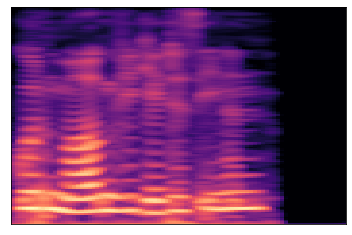

In [99]:
librosa.display.specshow(X_train[0][0].cpu().numpy(), sr=16000, hop_length=50)

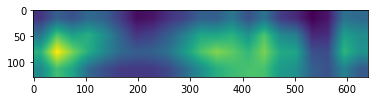

In [23]:
plt.imshow(grad_cam_map[0][0].cpu().numpy())

tensor([[[[0.4365, 0.4938, 0.2550, 0.1349, 0.1262, 0.1093, 0.0405, 0.0000,
           0.0364, 0.1889, 0.4840, 0.6210, 0.7551, 0.5636, 0.3607, 0.1797,
           0.2761, 0.3577, 0.3611, 0.3701, 0.2436],
          [0.6607, 0.9084, 0.7118, 0.5199, 0.3973, 0.2602, 0.1158, 0.0436,
           0.0521, 0.2760, 0.6813, 0.7795, 0.9113, 0.8144, 0.7058, 0.5295,
           0.5559, 0.5133, 0.5069, 0.6654, 0.4777],
          [0.6958, 1.0000, 0.9023, 0.6297, 0.5640, 0.4029, 0.2372, 0.1250,
           0.1482, 0.3083, 0.6952, 0.7495, 0.8290, 0.8069, 0.7165, 0.6138,
           0.6668, 0.5637, 0.4751, 0.5636, 0.4242],
          [0.4390, 0.5993, 0.5871, 0.3359, 0.2985, 0.1914, 0.1218, 0.0727,
           0.1026, 0.1497, 0.3850, 0.4681, 0.5134, 0.5149, 0.5295, 0.4880,
           0.5249, 0.4069, 0.3111, 0.3849, 0.2951]]]], device='cuda:0')

In [95]:
activation_map[0][1].size()

torch.Size([4, 21])

In [79]:



#mel_sample = librosa.util.normalize(mel_sample.cpu().squeeze().numpy()[0]) #수정 필요. min-max normalization

grad_result = activation_map[0][0].numpy() + to_min_max(X_train[0].view(3,128,641)).numpy()*255 # (1, 3, 244, 244)

fallout_list.append(grad_heatmap.numpy() - mel_sample)


plt.figure(figsize=(10,5))
plt.ion()
plt.subplot(131)
librosa.display.specshow(mel_sample, sr=sr, hop_length=50)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")